<a href="https://colab.research.google.com/github/gerardPlanella/DeepLearning1_UvA_22/blob/main/assignment2/assignment_2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning 1, Assignment 2: Transfer Learning for CNNs, Visual Prompting, Graph Neural Networks

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision

from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np

import gc

seed = 42

# Set the random seeds for reproducibility
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():  # GPU operation have separate seed
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.determinstic = True
    torch.backends.cudnn.benchmark = False

# Set default device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if(torch.cuda.is_available()):
    print("Using GPU: " + torch.cuda.get_device_name(device))
else:
    print("Using CPU")

Using GPU: GeForce GTX 1050


## Part 1: Transfer Learning for CNNs

### 1a: Model Comparison

We will compare the models VGG11, VGG11 with Batch Normalization, ResNet18, ResNet34, DenseNet121 and MobileNet-v3-Small using the Top-1 accuracy on Image Net. The models used are pre-trained from PyTorch.

In [ ]:
#Import Models to evaluate
from torchvision.models import vgg11, vgg11_bn, resnet18, resnet34, densenet121, mobilenet_v3_small

N_IMAGES = 10
IMAGE_DIM = 256
DATASET = "IMAGENET1K_V1"
fake_image = torch.rand(1, 3, IMAGE_DIM, IMAGE_DIM, dtype=torch.float)

model_info = {
    "VGG11": {"top1acc": 69.02, "n_params": 132863336, "inference_time_noGrad": None, "inference_time": None},
    "VGG11_BN": {"top1acc": 70.37, "n_params": 132863336, "inference_time_noGrad": None, "inference_time": None},
    "ResNet18": {"top1acc": 69.758, "n_params" : 11689512, "inference_time_noGrad": None, "inference_time": None},
    "ResNet34": {"top1acc": 73.314, "n_params": 21797672, "inference_time_noGrad": None, "inference_time": None},
    "DenseNet121": {"top1acc": 74.434, "n_params": 7978856, "inference_time_noGrad": None, "inference_time": None},
    "MobileNetV3_Small": {"top1acc": 67.668, "n_params": 2542856, "inference_time_noGrad": None, "inference_time": None}
}

models = {
    "VGG11": vgg11(weights=DATASET),
    "VGG11_BN":vgg11_bn(weights=DATASET),
    "ResNet18": resnet18(weights=DATASET),
    "ResNet34": resnet34(weights=DATASET),
    "DenseNet121": densenet121(weights=DATASET),
    "MobileNetV3_Small": mobilenet_v3_small(weights=DATASET)
}


Firstly, we evaluate the inference times for all the models with and without the torch.no_grad() parameter. We will process 50 images and average the inference time for each model.

In [ ]:
def get_inference_time(model, device, image, repetitions, no_grad = True):
    model.eval()
    model.to(device)
    image = image.to(device)
    times = np.zeros((repetitions, 1))
    start, end = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

    for i in range(20):
        _ = model(image)
    
    if no_grad:
        with torch.no_grad():
            for i in range(repetitions):
                start.record()
                _ = model(image)
                end.record()
                torch.cuda.synchronize()
                times[i] = start.elapsed_time(end)
    else:
        for i in range(repetitions):
            start.record()
            _ = model(image)
            end.record()
            torch.cuda.synchronize()
            times[i] = start.elapsed_time(end)

    
    time = np.sum(times) / repetitions
    model.cpu()
    image = image.cpu().detach()
    return time

N_REPETITONS = 50

for model_name in models.keys():
    model_info[model_name]["inference_time_noGrad"] = get_inference_time(models[model_name], device, fake_image, N_REPETITONS)
for model_name in models.keys():
    model_info[model_name]["inference_time"] = get_inference_time(models[model_name], device, fake_image, N_REPETITONS, no_grad=False)


We will now plot the results for the different models.

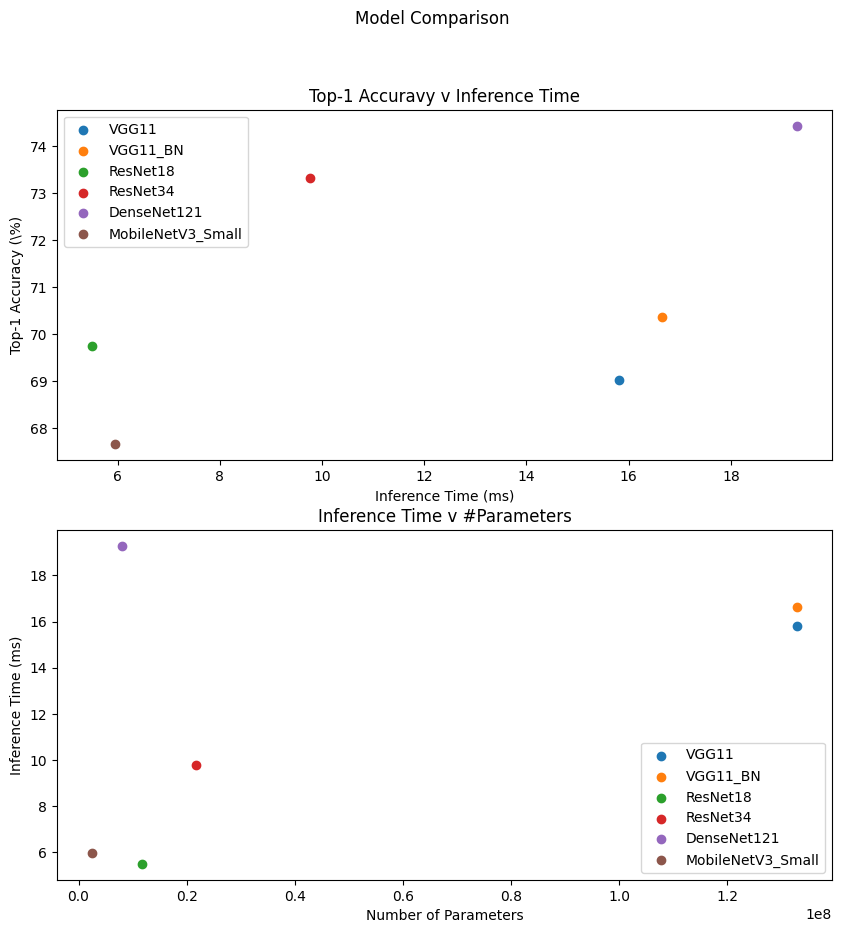

In [ ]:
def plot_model_info(model_info, x_axis_key, x_axs_label, y_axis_key, y_axis_label, title, ax):
    x = [model_info[name][x_axis_key] for name in model_info.keys()]
    x_keys = [name for name in model_info.keys()]

    y_no_grad = [model_info[name][y_axis_key] for name in x_keys]

    for x_val, x_label, y in zip(x, x_keys, y_no_grad):
        ax.scatter(x_val, y, label=x_label)

    ax.set_title(title)
    ax.set_xlabel(x_axs_label)
    ax.set_ylabel(y_axis_label)
    ax.legend()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

fig.suptitle("Model Comparison")

plot_model_info(model_info, "inference_time_noGrad", "Inference Time (ms)", "top1acc", "Top-1 Accuracy (\%)", "Top-1 Accuravy v Inference Time", ax1)
plot_model_info(model_info, "n_params", "Number of Parameters", "inference_time_noGrad", "Inference Time (ms)", "Inference Time v #Parameters", ax2)

plt.show()


What we can observe from these plots is that as the number of parameters increases, so does the inference time, which is to be expected. Nevertheless, this is not the case for DenseNet121. This relationship between inference time and # of parameters will be highly dependent on the network architecture.

In addition, we can also observe that Models with a higher Inference Time normally have a higher Top-1 Accuracy, which makes sense as the models with higher inference speeds will normally be more complex.

### 1b. Impact of torch.no_grad() on inference speed

We will now evaluate the effect that using torch.no_grad()has on our inference time.

In [ ]:
def plot_torch_nograd_inference(model_info, ax):
    x_keys = [name for name in model_info.keys()]

    y_no_grad = [model_info[name]["inference_time_noGrad"] for name in x_keys]
    y_grad = [model_info[name]["inference_time"] for name in x_keys]

    width = 0.35
    x = np.arange(len(x_keys))
    rects1 = ax.bar(x - width/2, y_no_grad, width, label="torch.nograd()")
    rects2 = ax.bar(x + width/2, y_grad, width, label="With Gradient")


    ax.set_title("Impact of torch.no_grad() on Inference Speed")
    ax.set_xticks(x, x_keys)
    ax.set_ylabel("Inference Time (ms)")
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3, label_type="center")
    
fig, ax = plt.subplots()
plot_torch_nograd_inference(model_info, ax)
plt.xticks(rotation=90)
fig.tight_layout()
plt.show()

We can see that using torch.no_grad() decreases our inference time. This is to be expected as when computing the forward pass, the no_grad flag will prevent the gpu from saving the outputs that would be used to calculate the backward pass. The time difference we see is given by the time needed to save to memory all of these intermediate values.

### 1c. GPU vRAM Usage with torch.no_grad()

This part will analyse the effect that torch.no_grad() has on the GPU vRAM usage in our forward passes. 

In [ ]:
def evaluate_memory_allocation(model, device, no_grad = True, image_dim = IMAGE_DIM):
    gc.collect()
    torch.cuda.empty_cache()
    
    mem = None
    model.eval()
    model.to(device)
    fake_batch = torch.rand(64, 3, image_dim, image_dim, dtype=torch.float)
    fake_batch = fake_batch.to(device)

    if no_grad:
        with torch.no_grad():
            mem_start = torch.cuda.memory_allocated()
            out = model(fake_batch)
            mem_end = torch.cuda.memory_allocated()
            mem = mem_end - mem_start
            
    else:
        mem_start = torch.cuda.memory_allocated()
        out = model(fake_batch)
        mem_end = torch.cuda.memory_allocated()
        mem = mem_end - mem_start
    
    del out
    model.cpu()
    fake_batch = fake_batch.cpu().detach()

    return mem
 

for model_name in models.keys():
    model_info[model_name]["memory_allocated_noGrad"] = evaluate_memory_allocation(models[model_name], device)
    model_info[model_name]["memory_allocated"] = evaluate_memory_allocation(models[model_name], device, no_grad=False)
    

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 3.95 GiB total capacity; 3.21 GiB already allocated; 148.06 MiB free; 3.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def plot_torch_nograd_memory(model_info, ax):
    x_keys = [name for name in model_info.keys()]

    y_no_grad = [model_info[name]["memory_allocated_noGrad"] for name in x_keys]
    y_grad = [model_info[name]["memory_allocated"] for name in x_keys]

    width = 0.35
    x = np.arange(len(x_keys))
    rects1 = ax.bar(x - width/2, y_no_grad, width, label="torch.nograd()")
    rects2 = ax.bar(x + width/2, y_grad, width, label="With Gradient")


    ax.set_title("Impact of torch.no_grad() on Memory Allocation")
    ax.set_xticks(x, x_keys)
    ax.set_ylabel("Inference Time (ms)")
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3, label_type="center")
    
fig, ax = plt.subplots()
plot_torch_nograd_memory(model_info, ax)
plt.xticks(rotation=90)
fig.tight_layout()
plt.show()